In [2]:
import numpy as np
from numpy.linalg import eigh
from functools import lru_cache
import tensorcircuit as tc
from collections import Counter
import quimb as qu
from scipy.stats import unitary_group
from scipy.linalg import expm
from scipy.linalg import sqrtm
import logging
from renormalizer import Model, Op, BasisHalfSpin, Mps, Mpo, optimize_mps
import itertools
from itertools import product
import matplotlib.pyplot as plt
print("当前 quimb 版本：", qu.__version__)
# 确保使用合适的计算后端 (tensorflow, jax, numpy)
tc.set_backend("numpy")

当前 quimb 版本： 1.10.0


numpy_backend

In [3]:
def apply_k_local_unitary(state, U, targets, n):
    """
    在 n 比特系统中，直接在态向量 state 上局部作用 k 比特酉矩阵 U
    targets: 作用位点列表，如 [1,2,3]
    """
    state = state.reshape([2] * n)  # reshape 成 tensor

    # 将目标比特移动到前面，其他维度放后面
    perm = targets + [i for i in range(n) if i not in targets]
    inv_perm = np.argsort(perm)

    state_perm = np.transpose(state, perm)
    k = len(targets)
    shape_k = (2,) * k
    shape_rest = (2,) * (n - k)
    state_perm = state_perm.reshape(2 ** k, -1)

    # 对每个后部坐标应用 U
    state_perm = U @ state_perm  # 作用在目标比特上

    # 还原回原始排列
    state_perm = state_perm.reshape(shape_k + shape_rest)
    state_new = np.transpose(state_perm, inv_perm)
    return state_new.reshape(-1)

def generate_ladder_state_efficient(n, k, seed=None):
    """
    高效生成随机链式锁定态（不构造大型矩阵）
    """
    if seed is not None:
        np.random.seed(seed)
    dim = 2 ** n
    state = np.zeros(dim, dtype=complex)
    state[0] = 1.0  # 初始为 |00...0>

    for start in range(n - k + 1):
        U = unitary_group.rvs(2 ** k)
        targets = list(range(start, start + k))
        state = apply_k_local_unitary(state, U, targets, n)

    return state
def expand_random_k_unitary(U, start, k, n):
    """
    将一个 k 比特酉矩阵 U 作用在 n 比特系统的 [start, ..., start+k-1] 上
    """
    dim = 2 ** n
    result = np.zeros((dim, dim), dtype=complex)

    targets = list(range(start, start + k))

    for bits_in in product([0, 1], repeat=n):
        for bits_out in product([0, 1], repeat=n):
            if all(bits_in[t] == bits_out[t] for t in range(n) if t not in targets):
                in_sub = [bits_in[t] for t in targets]
                out_sub = [bits_out[t] for t in targets]

                in_idx = int("".join(str(b) for b in in_sub), 2)
                out_idx = int("".join(str(b) for b in out_sub), 2)

                i_idx = int("".join(str(b) for b in bits_in), 2)
                j_idx = int("".join(str(b) for b in bits_out), 2)

                result[i_idx, j_idx] = U[in_idx, out_idx]
    return result

def generate_random_ladder_state(n, k, seed=None):
    """
    从 |0...0⟩ 出发，自动以阶梯结构作用 n-k+1 个随机 k 比特酉矩阵，返回最终状态向量
    """
    assert k <= n, "作用的比特数 k 不能大于总比特数 n"

    if seed is not None:
        np.random.seed(seed)

    dim = 2 ** n
    state = np.zeros(dim, dtype=complex)
    state[0] = 1.0  # 初始态为 |0...0⟩

    for start in range(n - k + 1):
        U = unitary_group.rvs(2 ** k)  # 随机生成 k 比特酉矩阵
        U_full = expand_random_k_unitary(U, start, k, n)
        state = U_full @ state
    return state

def construct_spin_orbit_locked_state(n, theta=0.0, l_plus_idx=None, l_minus_idx=None):
    """
    构造 n 比特系统中具有自旋-轨道锁定的态向量。
    
    参数：
        n: 总比特数（>=2），其中第0位表示spin，其余为OAM
        theta: 旋转角参数
        l_plus_idx: OAM部分中 |l=+q⟩ 的索引（在 [0, 2**(n-1) - 1] 范围）
        l_minus_idx: OAM部分中 |l=-q⟩ 的索引

    返回：
        psi: (2**n,) 的复数态向量
    """
    assert n >= 2, "至少需要一个 spin 和一个 OAM 比特"
    dim = 2 ** n
    oam_dim = 2 ** (n - 1)
    
    # 默认选择 |l=+q⟩ = |00...0⟩，|l=-q⟩ = |11...1⟩
    if l_plus_idx is None:
        l_plus_idx = 0
    if l_minus_idx is None:
        l_minus_idx = oam_dim - 1

    # 构造 σ⁻ 和 σ⁺
    sigma_minus = (np.array([1, -1j]) / np.sqrt(2))
    sigma_plus  = (np.array([1,  1j]) / np.sqrt(2))
    
    # 构造 OAM 态
    oam_plus  = np.zeros(oam_dim, dtype=complex)
    oam_minus = np.zeros(oam_dim, dtype=complex)
    oam_plus[l_plus_idx]   = 1.0
    oam_minus[l_minus_idx] = 1.0

    # Kronecker 外积得到完整态（spin × OAM）
    term1 = np.kron(np.exp(1j * theta) * sigma_minus, oam_plus)
    term2 = np.kron(np.exp(-1j * theta) * sigma_plus,  oam_minus)

    # 合成并归一化
    psi = (term1 + term2) / np.sqrt(2)
    return psi

def get_spin_state_vector(n, spin_levels):
    """
    计算 |s_12, s_123, ..., s_n, s_z> 状态对应的态矢量。

    参数：
    - n: 自旋-1/2粒子的数量。
    - spin_levels: 列表，[s_12, s_123, ..., s_n, s_z]，
                   依次为每步耦合得到的总自旋值，以及最终态的总磁量子数 s_z（总自旋的投影）。

    返回：
    - 对应态的状态向量（numpy 数组，长度 2^n）。
    """
    if n < 1:
        raise ValueError("n 必须是正整数")
    if len(spin_levels) != n:
        raise ValueError("spin_levels 列表长度应为 n（包含 n-1 个中间总自旋和最终的 s_z）")
    # 拆分中间总自旋序列和最终 s_z
    intermediate_s = spin_levels[:-1]
    final_m = spin_levels[-1]
    # n=1 特殊处理：只有一个自旋
    if n == 1:
        if abs(final_m) != 0.5:
            raise ValueError("对于单个自旋，m 必须是 ±0.5")
        # 返回 [1, 0] 表示 |↑>，或 [0, 1] 表示 |↓>
        return np.array([1.0, 0.0]) if final_m == 0.5 else np.array([0.0, 1.0])
    # 校验 intermediate_s 长度
    if len(intermediate_s) != n - 1:
        raise ValueError("spin_levels 应包含 n-1 个总自旋值加最终 s_z")
    # 校验物理可行性：逐步检查每次耦合 s 值是否满足 j = j_prev ± 1/2
    prev_s = 0.5  # 第一个自旋的总自旋
    for s_val in intermediate_s:
        # 可能的耦合结果（去除负值的情况）
        allowed = set([abs(prev_s - 0.5), prev_s + 0.5])
        allowed = {x for x in allowed if x >= 0}
        # 判断给定 s_val 是否在 allowed 集合（考虑浮点误差）
        if not any(abs(s_val - a) < 1e-8 for a in allowed):
            raise ValueError(f"耦合不一致：无法从自旋 {prev_s} 加 1/2 得到 {s_val}")
        prev_s = s_val
    total_S = intermediate_s[-1]
    # 检查最终 m 是否在 [-S, S] 范围内
    if abs(final_m) > total_S + 1e-8:
        raise ValueError("最终 m 超出总自旋范围")

    # 将自旋值转换为 2*j 的整数形式，便于处理半整数
    def to_2j(x):
        return int(round(x * 2))

    # 使用缓存的递归函数逐步耦合
    @lru_cache(maxsize=None)
    def couple(i, j1_twice, m1_twice):
        """
        返回前 i 个自旋（总自旋 j1_twice/2， 磁量子数 m1_twice/2）的态矢量。
        参数:
        - i: 耦合的自旋数目
        - j1_twice: 前 i 个自旋的总自旋的两倍 (2*s_i)
        - m1_twice: 该态总磁量子数的两倍 (2*m_i)
        """
        # 基础：单个自旋态
        if i == 1:
            # 单个自旋 j 必须为 1 (即 2*0.5)
            if j1_twice != 1:
                raise ValueError("单个自旋的总自旋应为 1/2")
            if m1_twice == 1:  # |↑>
                return np.array([1.0, 0.0])
            elif m1_twice == -1:  # |↓>
                return np.array([0.0, 1.0])
            else:
                raise ValueError("单个自旋的 m 必须为 ±0.5")
        # 确定前 i-1 个自旋的总自旋 j_prev_twice
        if i == 2:
            # 前1个自旋总自旋固定为1/2（j_prev_twice=1）
            j_prev_twice = 1
        else:
            # 对于 i>2，从 intermediate_s 获取前 i-1 个自旋的总自旋
            j_prev_twice = to_2j(intermediate_s[i - 3])
        j_curr_twice = j1_twice  # 当前 i 个自旋的 2*j 值
        M_twice = m1_twice  # 当前总 m 的两倍
        j2_twice = 1  # 新加入的单个自旋(1/2)的 2*j 值为1
        # 初始化长度 2^i 的零向量
        state_vec = np.zeros(2 ** i)
        # 遍历第 i 个自旋的可能 m ( +1/2 或 -1/2 )
        for m2_twice in (1, -1):
            m1_prev_twice = M_twice - m2_twice  # 前 i-1 个自旋需承担的磁量子数之和 (2*m_prev)
            # 判断 m1_prev_twice 是否在前 i-1 个自旋总自旋范围内
            if abs(m1_prev_twice) <= j_prev_twice and (j_prev_twice - m1_prev_twice) % 2 == 0:
                # 判断耦合的总自旋是否匹配期望值
                # 只能在 j_prev ± 1 范围内取到 j_curr_twice
                if not (j_curr_twice == j_prev_twice + j2_twice or j_curr_twice == abs(j_prev_twice - j2_twice)):
                    continue  # 若不匹配，系数为0，跳过
                # 将量子数从 2*j 表示转换回实际值用于公式计算
                j_prev = j_prev_twice / 2.0
                m_prev = m1_prev_twice / 2.0
                j_curr = j_curr_twice / 2.0
                M = M_twice / 2.0
                m2 = m2_twice / 2.0  # 新粒子的 m（±0.5）
                # 根据大/小耦合支路使用对应公式计算 CG 系数
                if abs(j_curr - (j_prev + 0.5)) < 1e-8:
                    # 情况1： j_curr = j_prev + 1/2
                    if m2 == 0.5:
                        cgc = np.sqrt((j_prev + M + 0.5) / (2 * j_prev + 1))
                    else:  # m2 = -0.5
                        cgc = np.sqrt((j_prev - M + 0.5) / (2 * j_prev + 1))
                else:
                    # 情况2： j_curr = j_prev - 1/2
                    if m2 == 0.5:
                        cgc = np.sqrt((j_prev - M + 0.5) / (2 * j_prev + 1))
                    else:  # m2 = -0.5
                        cgc = -np.sqrt((j_prev + M + 0.5) / (2 * j_prev + 1))
                if abs(cgc) < 1e-12:
                    continue  # 系数近似为0，不计入
                # 递归获得前 i-1 个自旋的态矢量
                prev_state = couple(i - 1, j_prev_twice, m1_prev_twice)
                # 构造第 i 个自旋对应的基向量
                spin_state = np.array([1.0, 0.0]) if m2 == 0.5 else np.array([0.0, 1.0])
                # 计算张量积并按系数加权累加
                state_vec += cgc * np.kron(prev_state, spin_state)
        return state_vec
    # 调用递归函数获取最终 n 个自旋的态矢量
    # print(intermediate_s[-1])
    total_j_twice = to_2j(intermediate_s[-1])  # 2 * s_n
    # print(total_j_twice)
    total_m_twice = to_2j(final_m)  # 2 * s_z
    state = couple(n, total_j_twice, total_m_twice)
    # （可选）规范化结果向量（正常情况下 CG 系数保证规范归一，这里做一下保险处理）
    norm = np.linalg.norm(state)
    if norm < 1e-12:
        raise ValueError("计算得到的态矢量归一化因子接近0，请检查输入参数的有效性")
    return state / norm
def generate_w_state(n):
    """
    生成 n 比特的 W 态态矢量
    返回：
        state_vector: 形状为 (2**n,) 的 numpy 复数数组，已归一化
    """
    dim = 2 ** n
    state_vector = np.zeros(dim, dtype=np.complex128)
    for i in range(n):
        # 第 i 个位置为 '1'，其余为 '0'
        bitstring = ['0'] * n
        bitstring[i] = '1'
        index = int(''.join(bitstring), 2)
        state_vector[index] = 1.0
    # 归一化
    state_vector /= np.sqrt(n)
    return state_vector
def generate_neel_state(n):
    # 创建长度为2^n的零向量
    state = np.zeros(2**n, dtype=np.complex128)
    
    # 生成交替自旋的二进制表示，例如：10101010...对于n=8
    binary_state = ''.join(['0' if i % 2 == 0 else '1' for i in range(n)])
    
    # 将对应二进制数的位置设为1
    state[int(binary_state, 2)] = 1
    return state
def generate_random_state(n):
    """
    生成一个 n 比特的随机纯态（复数），归一化。
    
    参数：
        n: 量子比特数
    返回：
        state_vector: 形状为 (2**n,) 的归一化复数 numpy 数组
    """
    dim = 2 ** n
    # 复高斯分布实部+虚部（独立标准正态）
    real_part = np.random.randn(dim)
    imag_part = np.random.randn(dim)
    state_vector = real_part + 1j * imag_part
    # 归一化
    state_vector /= np.linalg.norm(state_vector)

    return state_vector
def generate_ghz_state(n):
    """
    生成 n 比特 GHZ 态的态矢量
    """
    dim = 2 ** n
    state_vector = np.zeros(dim, dtype=np.complex128)
    # |000...0> 的索引是 0，|111...1> 的索引是 2^n - 1
    state_vector[0] = 1.0 / np.sqrt(2)
    state_vector[-1] = 1.0 / np.sqrt(2)
    return state_vector

In [4]:
from scipy.linalg import expm
# Pauli 基定义
pauli_ops = {
    'I': np.array([[1, 0], [0, 1]], dtype=np.complex128),
    'X': np.array([[0, 1], [1, 0]], dtype=np.complex128),
    'Y': np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
    'Z': np.array([[1, 0], [0, -1]], dtype=np.complex128),
    '+': np.array([[0, 1], [0, 0]], dtype=np.complex128),  # σ^+
    '-': np.array([[0, 0], [1, 0]], dtype=np.complex128),  # σ^-
    "RX": (1/2) * np.array([[1, -1j], [-1j, 1]]),
    "RY": (1/2) * np.array([[1, -1], [1, 1]]),
    "RZ":  np.array([[0.5, 0], [0, 0.5]], dtype=np.complex128)
}

# 构造n比特上某两个位置作用的多体算符
def build_manybody_operator(n, op_string):
    op = 1
    for p in op_string:
        op = np.kron(op, pauli_ops[p])
    return op

# 构造严格意义上的 H_XY 哈密顿量
def XY_Hamiltonian(n, J, B, alpha):
    H = np.zeros((2**n, 2**n), dtype=np.complex128)

    for i in range(n - 1):
        for j in range(i + 1, n):
            Jij = J / abs(i - j)**alpha

            # σ⁺_i σ⁻_j
            ops1 = ['I'] * n
            ops1[i] = '+'
            ops1[j] = '-'
            H += Jij * build_manybody_operator(n, ops1)

            # σ⁻_i σ⁺_j
            ops2 = ['I'] * n
            ops2[i] = '-'
            ops2[j] = '+'
            H += Jij * build_manybody_operator(n, ops2)

    # 场项 B σ^z
    for i in range(n):
        opsz = ['I'] * n
        opsz[i] = 'Z'
        H += B * build_manybody_operator(n, opsz)
    return H
#时间演化
def time_evolution(state, H, t):
    U = expm(-1j * H * t)  # 演化算符
    return np.dot(U, state)

# 计算 <σ_i σ_j> - <σ_i><σ_j>
def two_point_correlation(state, pauli1, pauli2, i, j, n):
    def build_op(p1, p2, i, j, n):
        # 初始化 ops 为全 I 的操作符列表
        ops = [pauli_ops["I"]] * n
        # 根据位置i和j进行相应的乘法操作
        if i == j:
            if p1 =="I":
                ops[i] = pauli_ops[p2]
            elif p2 =="I":
                ops[i] = pauli_ops[p1]
            else:
                ops[i] = pauli_ops[p1]*pauli_ops[p2]
        else:
            ops[i] = pauli_ops[p1]  # 第 i 位置的操作符乘以 pauli1
            ops[j] = pauli_ops[p2]  # 第 j 位置的操作符乘以 pauli2
        
        # 逐步计算 Kronecker 积
        result = ops[0]
        for op in ops[1:]:
            result = np.kron(result, op)
        return result

    # 构建自旋算符
    op1 = build_op(pauli1, "I", i, j, n)
    op2 = build_op("I", pauli2, i, j, n)
    op12 = build_op(pauli1, pauli2, i, j, n)

    # 计算期望值
    s1 = np.real(state.conj().T @ op1 @ state)
    s2 = np.real(state.conj().T @ op2 @ state)
    s12 = np.real(state.conj().T @ op12 @ state)

    return s12-s1 * s2

# 构造整张图的矩阵
def build_corr_matrix(state, pauli1, pauli2, n):
    mat = np.zeros((n, n))
 
    for i in range(n):
        for j in range(n):
            mat[i, j] = two_point_correlation(state, pauli1, pauli2, i, j, n)
    return mat


In [6]:
n=8
k=3     # 局部测量比特数
np.random.seed(12)
# state_1=[0,0.5,0,0]
# state_2=[0,0.5,1,0]
# state_3=[1,1.5,2,1]
# state_vector =generate_ghz_state(n)
# state_vector = (get_spin_state_vector(n, state_1)+get_spin_state_vector(n, state_2))*np.sqrt(0.5)
# state_vector = get_spin_state_vector(n, state_3)
# state_vector=generate_random_state(n)
# state_vector = generate_w_state(n)
# state_vector = construct_spin_orbit_locked_state(n=n, theta=np.pi/3)
# state_vector =generate_random_ladder_state(n=n, k=2, seed=12)
# state_vector =generate_ladder_state_efficient(n=n, k=3, seed=12)
state_vector = generate_neel_state(n)
# state_vector=neel_state
# state_vector =np.array([0,np.sqrt(0.5),np.sqrt(0.5),0])
# print("状态向量:", state_vector)
# 创建哈密顿量
J = 1  # 假设相互作用强度
B = 0  # 横向场强度
alpha=1.8
H = XY_Hamiltonian(n, J, B,alpha)
t =0.3# 演化时间
# evolved_state=state_vector
evolved_state = time_evolution(state_vector, H, t)
print(evolved_state)

[ 0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j         -3.66160052e-03+0.00501007j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j         -9.57317652e-03-0.007245j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j         -9.89073137e-03+0.01134509j
  0.00000000e+00+0.j         -2.65825927e-02-0.02123768j
 -6.75294578e-03+0.00942679j  0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j          0.00000000e+00+0.j
  0.00000000e+00+0.j         -9.8907313

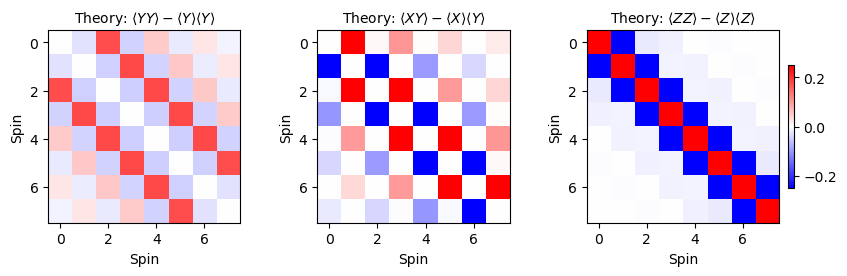

In [7]:
# 计算三个相关矩阵
mat_YY = build_corr_matrix(evolved_state, "Y", "Y", n)
mat_XY = build_corr_matrix(evolved_state, "X", "Y", n)
mat_ZZ = build_corr_matrix(evolved_state, "Z", "Z", n)
# 绘图
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, mat, title in zip(
    axs,
    [mat_YY, mat_XY, mat_ZZ],
    [r"Theory: $\langle YY\rangle - \langle Y\rangle\langle Y\rangle$",
     r"Theory: $\langle XY\rangle - \langle X\rangle\langle Y\rangle$",
     r"Theory: $\langle ZZ\rangle - \langle Z\rangle\langle Z\rangle$"]
):
    im = ax.imshow(mat, cmap="bwr", vmin=-0.25, vmax=0.25)  # 设置vmin和vmax以确保一致性
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Spin", fontsize=10)
    ax.set_ylabel("Spin", fontsize=10)

# 调整子图间距，避免颜色条与图形重叠
fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.85)  # 调整右侧边距以为颜色条腾出空间
# 将颜色条放置在最右侧，并设置为竖直方向
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.4, pad=0.01)
cbar.ax.tick_params(labelsize=10)  # 调整颜色条刻度标签的字体大小
plt.show()

In [8]:
def generate_all_bitstrings(m):
    return [''.join(bits) for bits in product('01', repeat=m)]

# 展开测量基
def expand_measurement_basis(n, k, basis):
    return (basis * ((n // k) + 1))[:n]

# 应用测量门到态矢量
def apply_measurement_gate(state, basis):
    state = state.copy()
    for q, b in enumerate(basis):
        if b == "X":
            U = (1/np.sqrt(2)) * np.array([[1, 1], [-1, 1]])
            
        elif b == "Y":
            U = (1/np.sqrt(2)) * np.array([[1, -1j], [-1j, 1]])
        else:  # Z 或 I 不处理
            continue
        state = apply_single_qubit_gate(state, U, q)
    return state

def apply_single_qubit_gate(state, gate, qubit):
    n = int(np.log2(len(state)))
    state = state.reshape([2] * n)
    state = np.tensordot(gate, state, axes=[1, qubit])
    axes_order = list(range(1, qubit+1)) + [0] + list(range(qubit+1, n))
    state = np.transpose(state, axes_order).reshape(-1)
    return state

# 获取精确概率分布（无抽样）
def get_exact_probabilities(state_vector, n, k):
    pauli_bases = ["X", "Y", "Z"]
    measurement_bases = list(product(pauli_bases, repeat=k))
    all_bitstrings_n = generate_all_bitstrings(n)
    
    probabilities = {}
    raw_counts = {}
    for basis in measurement_bases:
        expanded_basis = expand_measurement_basis(n, k, basis)
        final_state = apply_measurement_gate(state_vector, expanded_basis)
        probs = np.abs(final_state) ** 2
        
        # 存储精确概率，不再进行抽样计数
        probabilities[tuple(expanded_basis)] = probs
        raw_counts[tuple(expanded_basis)] = dict(zip(all_bitstrings_n, probs))

    return probabilities, raw_counts, all_bitstrings_n



In [9]:
# 获取 POVM 概率向量
probabilities, raw_probs, bitstrings = get_exact_probabilities(evolved_state, n, k)

In [10]:
# 显示部分结果
print("\n 测量基数：", len(probabilities))
for key, ps in list(probabilities.items())[:3]:  # 显示前3组
    print(f"\n测量基 {key} 下的 p_s（前10项）:")
    print(ps[:15])


 测量基数： 27

测量基 ('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X') 下的 p_s（前10项）:
[0.00707464 0.00559022 0.00605975 0.00395831 0.00470959 0.0068199
 0.00281654 0.00430718 0.00509275 0.00307345 0.00720388 0.00478819
 0.00215142 0.00301434 0.00354377]

测量基 ('X', 'X', 'Y', 'X', 'X', 'Y', 'X', 'X') 下的 p_s（前10项）:
[7.88241375e-04 9.34247436e-04 3.65578913e-04 3.23955814e-04
 8.14202781e-05 9.15908186e-05 4.69687623e-04 4.93204583e-04
 5.06936655e-04 4.66250740e-04 1.85001093e-04 1.23706298e-04
 4.08008376e-04 3.73577934e-04 1.42094191e-03]

测量基 ('X', 'X', 'Z', 'X', 'X', 'Z', 'X', 'X') 下的 p_s（前10项）:
[3.98234497e-03 3.55407053e-03 4.98331956e-04 3.82081086e-06
 8.67960144e-03 9.49328976e-03 1.00460405e-02 9.53842559e-03
 5.31683258e-04 1.29074575e-05 3.97688163e-03 3.43550295e-03
 1.08393163e-02 9.69985977e-03 1.36733637e-02]


In [11]:
# 提取局部概率
def extract_local_probs_grouped_by_window(raw_probs, n, k):
    local_probs = {i: {} for i in range(n - k + 1)}
    all_bitstrings_k = generate_all_bitstrings(k)
    for full_basis, global_probs in raw_probs.items():
        for i in range(n - k + 1):
            local_basis = tuple(full_basis[i:i + k])
            local_probs_vector = np.zeros(2 ** k)
            for global_bitstr, prob in global_probs.items():  # ← 关键修正
                local_bitstr = global_bitstr[i:i + k]
                local_idx = int(local_bitstr, 2)
                local_probs_vector[local_idx] += prob
            local_probs[i][local_basis] = local_probs_vector

    return local_probs

# 补全4^k基概率
def expand_all_local_pauli_bases(k):
    return list(product(['I', 'X', 'Y', 'Z'], repeat=k))

def complete_local_probs_from_measured(local_probs_by_window, k):
    full_pauli_bases = expand_all_local_pauli_bases(k)
    completed_local_probs = {}
    for i, basis_data in local_probs_by_window.items():
        completed_local_probs[i] = {}
        for target_basis in full_pauli_bases:
            compatible_measured_bases = [
                mb for mb in basis_data
                if all(tb == 'I' or tb == mb for tb, mb in zip(target_basis, mb))
            ]

            if not compatible_measured_bases:
                completed_local_probs[i][target_basis] = None
                continue

            mask = [b == 'I' for b in target_basis]
            prob_sum = np.zeros(2 ** k)
            for cbasis in compatible_measured_bases:
                pvec = basis_data[cbasis]
                prob_sum += pvec
            completed_local_probs[i][target_basis] = prob_sum / len(compatible_measured_bases)

    return completed_local_probs

In [12]:
# 原始滑窗提取数据
local_probs_by_window = extract_local_probs_grouped_by_window(raw_probs, n, k)

# 补全所有 4^k 基的概率向量
completed_local_probs = complete_local_probs_from_measured(local_probs_by_window, k)

# 展示前几个窗口和基的结果
for i in range(min(4, n - k + 1)):
    print(f"\n 窗口位置 {i}：")
    cnt = 0
    for b, p in completed_local_probs[i].items():
        if p is not None:
            print(f"  基 {b}: p[:4] = {p}")
            cnt += 1
       


 窗口位置 0：
  基 ('I', 'I', 'I'): p[:4] = [0.14534431 0.09374311 0.25335087 0.14513174 0.08325175 0.06748183
 0.12899232 0.08270407]
  基 ('I', 'I', 'X'): p[:4] = [0.15382508 0.08526233 0.17896873 0.21951388 0.07911514 0.07161845
 0.08809105 0.12360534]
  基 ('I', 'I', 'Y'): p[:4] = [0.09848913 0.14059829 0.23545556 0.16302705 0.05089571 0.09983787
 0.1151596  0.09653679]
  基 ('I', 'I', 'Z'): p[:4] = [0.18371871 0.0553687  0.34562831 0.05285431 0.11974441 0.03098918
 0.18372631 0.02797008]
  基 ('I', 'X', 'I'): p[:4] = [0.13945975 0.13266915 0.25923542 0.1062057  0.12048421 0.10738688
 0.09175986 0.04279902]
  基 ('I', 'X', 'X'): p[:4] = [0.13517747 0.13695144 0.19761634 0.16782478 0.10357862 0.12429248
 0.06362757 0.07093131]
  基 ('I', 'X', 'Y'): p[:4] = [0.06061737 0.21151154 0.27332732 0.0921138  0.06404957 0.16382153
 0.10200574 0.03255314]
  基 ('I', 'X', 'Z'): p[:4] = [0.22258441 0.04954449 0.30676261 0.05867851 0.19382445 0.03404664
 0.10964626 0.02491262]
  基 ('I', 'Y', 'I'): p[:4] = [

In [13]:
def pauli_string_expectation(pvec, basis, all_bitstrings):
    """给定概率向量 p(x)，和 Pauli 基 basis，计算期望值 ⟨P⟩"""
    expval = 0.0
    for idx, bitstr in enumerate(all_bitstrings):
        val = 1.0
        for i, pauli in enumerate(basis):
            if pauli == 'I':
                continue
            elif pauli in ['X', 'Y', 'Z']:
                bit = int(bitstr[i])
                val *= 1 if bit == 0 else -1
        expval += pvec[idx] * val
    return expval
def compute_all_expectations(completed_local_probs, k):
    """计算所有窗口中所有 4^k 基的期望值"""
    all_bitstrings = generate_all_bitstrings(k)
    all_expectations = {}

    for i, basis_dict in completed_local_probs.items():
        all_expectations[i] = {}
        for basis, pvec in basis_dict.items():
            if pvec is None:
                all_expectations[i][basis] = None
            else:
                expval = pauli_string_expectation(pvec, basis, all_bitstrings)
                all_expectations[i][basis] = expval
    return all_expectations

In [14]:
all_expectations = compute_all_expectations(completed_local_probs, k)

# 查看前两个窗口前几个基的期望值
for i in range(min(5, len(all_expectations))):
    print(f"\n窗口 {i}：")
    cnt = 0
    for b, v in all_expectations[i].items():
        if v is not None:
            print(f"  基 {b} 的期望值 ⟨P⟩ = {v}")
            cnt += 1
       



窗口 0：
  基 ('I', 'I', 'I') 的期望值 ⟨P⟩ = 0.999999999999999
  基 ('I', 'I', 'X') 的期望值 ⟨P⟩ = -4.163336342344337e-17
  基 ('I', 'I', 'Y') 的期望值 ⟨P⟩ = 1.3877787807814457e-17
  基 ('I', 'I', 'Z') 的期望值 ⟨P⟩ = 0.6656354714960993
  基 ('I', 'X', 'I') 的期望值 ⟨P⟩ = 0.0
  基 ('I', 'X', 'X') 的期望值 ⟨P⟩ = -0.04497564661972034
  基 ('I', 'X', 'Y') 的期望值 ⟨P⟩ = -0.5013322590983172
  基 ('I', 'X', 'Z') 的期望值 ⟨P⟩ = 1.0408340855860843e-17
  基 ('I', 'Y', 'I') 的期望值 ⟨P⟩ = 2.7755575615628914e-17
  基 ('I', 'Y', 'X') 的期望值 ⟨P⟩ = 0.5013322590983171
  基 ('I', 'Y', 'Y') 的期望值 ⟨P⟩ = -0.04497564661972031
  基 ('I', 'Y', 'Z') 的期望值 ⟨P⟩ = 0.0
  基 ('I', 'Z', 'I') 的期望值 ⟨P⟩ = -0.6610740203395036
  基 ('I', 'Z', 'X') 的期望值 ⟨P⟩ = 5.551115123125783e-17
  基 ('I', 'Z', 'Y') 的期望值 ⟨P⟩ = -2.7755575615628914e-17
  基 ('I', 'Z', 'Z') 的期望值 ⟨P⟩ = -0.6942749511019086
  基 ('X', 'I', 'I') 的期望值 ⟨P⟩ = 5.551115123125783e-17
  基 ('X', 'I', 'X') 的期望值 ⟨P⟩ = 0.1750108749852746
  基 ('X', 'I', 'Y') 的期望值 ⟨P⟩ = 0.006905264685119372
  基 ('X', 'I', 'Z') 的期望值 ⟨P⟩ = 1.31838

In [15]:
def reconstruct_rho_from_expectations(expectations_dict, k):
    """
    将期望值 ⟨P⟩ 构造成密度矩阵：ρ = 1/2^k ∑⟨P⟩ P
    参数：
        expectations_dict: dict[basis (tuple of str)] = ⟨P⟩
        k: 窗口长度
    返回：
        rho: 2^k × 2^k 的密度矩阵
    """
    dim = 2 ** k
    rho = np.zeros((dim, dim), dtype=np.complex128)
    
    for pauli_str, coeff in expectations_dict.items():
        if coeff is None:
            continue
        op = pauli_ops[pauli_str[0]]
        for p in pauli_str[1:]:
            op = np.kron(op, pauli_ops[p])
        rho += coeff * op
    rho = rho / dim
    return rho
def compute_all_local_density_matrices(all_expectations, k):
    """
    计算所有窗口的局部密度矩阵
    返回：dict[window] = rho (2^k × 2^k array)
    """
    local_rhos = {}
    for i, exp_dict in all_expectations.items():
        rho = reconstruct_rho_from_expectations(exp_dict, k)
        local_rhos[i] = rho
    return local_rhos


In [16]:
local_density_matrices = compute_all_local_density_matrices(all_expectations, k)
# 打印前两个窗口的局部密度矩阵
for i in sorted(local_density_matrices.keys()):
    print(f"\n 窗口 {i} 的 ρ_{i+1}...{i+k} 密度矩阵：")
    print(local_density_matrices[i])


 窗口 0 的 ρ_1...3 密度矩阵：
[[ 1.70132144e-03+0.00000000e+00j  9.52742659e-18+5.00088252e-18j
   9.86623977e-18+6.17995238e-18j -3.46944695e-18+0.00000000e+00j
   3.55618313e-17-2.60208521e-18j -2.77555756e-17-1.38777878e-17j
   6.07153217e-18+3.46944695e-17j -1.43114687e-17+2.16840434e-17j]
 [ 9.52742659e-18-5.00088252e-18j  8.22458524e-02+0.00000000e+00j
  -2.48604797e-02-2.47495401e-01j -2.92734587e-18+2.49366500e-18j
   7.88839985e-02-3.31467168e-03j -8.67361738e-19+1.30104261e-17j
  -6.50521303e-18-4.33680869e-18j -9.54097912e-18+0.00000000e+00j]
 [ 9.86623977e-18-6.17995238e-18j -2.48604797e-02+2.47495401e-01j
   7.53522000e-01+0.00000000e+00j -1.82010440e-17+1.19126714e-17j
  -1.38456007e-02+2.38688976e-01j  1.34441069e-17+8.67361738e-19j
   1.12757026e-17+7.80625564e-18j -1.04083409e-17+2.08166817e-17j]
 [-3.46944695e-18+0.00000000e+00j -2.92734587e-18-2.49366500e-18j
  -1.82010440e-17-1.19126714e-17j  7.52409015e-02+0.00000000e+00j
   7.37257477e-18+1.64798730e-17j -4.87930065e-04+

In [17]:
def construct_R_operator(pvec_dict, rho, k):
    """
    构造真实的 R 算符，用于 MLE 优化：
    R = ∑_l (f_l / p_l) * P_l
    正确处理：I位不区分、f_l合并、用本征态密度矩阵构造。
    """
    dim = 2 ** k
    all_bitstrings = generate_all_bitstrings(k)
    R = np.zeros((dim, dim), dtype=complex)

    for basis, prob_vector in pvec_dict.items():
        sum=0
        if prob_vector is None:
            continue

        # Step1: 先生成有效位索引（非I位）
        active_indices = [i for i, p in enumerate(basis) if p != 'I']
        # Step2: 合并频率
        f_eff = dict()
        for idx, bitstr in enumerate(all_bitstrings):
            eff_bitstr = ''.join(bitstr[i] for i in active_indices)
            if eff_bitstr not in f_eff:
                f_eff[eff_bitstr] = 0.0
            f_eff[eff_bitstr] += prob_vector[idx]
        # Step3: 遍历每个有效bitstring
        for eff_bitstr, f_l in f_eff.items():
            full_bitstr = list('0' * k)
            idx_eff = 0
            for i in range(k):
                if basis[i] != 'I':
                    full_bitstr[i] = eff_bitstr[idx_eff]
                    idx_eff += 1
            full_bitstr = ''.join(full_bitstr)
            # 构造对应的 P_l
            P_l = np.eye(1, dtype=np.complex128)
            eigen=1
            for i, pauli in enumerate(basis):
                
                if pauli == 'I':
                    op = np.eye(2, dtype=np.complex128)
                else:
                    bit = int(full_bitstr[i])
                    if pauli == 'X':
                        if bit == 0:
                            vec = (1/np.sqrt(2)) * np.array([1, 1], dtype=np.complex128)
                            eigen *= +1
                        else:
                            vec = (1/np.sqrt(2)) * np.array([1, -1], dtype=np.complex128)
                            eigen *= -1
                    elif pauli == 'Y':
                        if bit == 0:
                            vec = (1/np.sqrt(2)) * np.array([1, 1j], dtype=np.complex128)
                            eigen *= +1
                        else:
                            vec = (1/np.sqrt(2)) * np.array([1, -1j], dtype=np.complex128)
                            eigen *= -1
                    elif pauli == 'Z':
                        if bit == 0:
                            vec = np.array([1, 0], dtype=np.complex128)
                            eigen *= +1
                        else:
                            vec = np.array([0, 1], dtype=np.complex128)
                            eigen *= -1
                    else:
                        raise ValueError(f"未知Pauli符号: {pauli}")
                    op = np.outer(vec, vec.conj())  # 
                P_l = np.kron(P_l, op)
            # 计算预测概率
            p_l = np.trace(P_l @ (rho)).real
            if p_l > 1e-16:
                R += (f_l / p_l) * P_l
          
    return R

def random_positive_density_matrix(k):
    """生成随机半正定的2^k阶密度矩阵"""
    dim = 2 ** k
    A = np.ones((dim, dim), dtype=np.complex128)
    rho = A @ A.conj().T
    rho /= np.trace(rho)
    return rho

def mle_with_real_R_fixed_iter(rho_init, pvec_dict, k, max_iter, error):
    rho = rho_init.copy()
    for it in range(max_iter):
        print(f"第{it}轮迭代")
        R = construct_R_operator(pvec_dict, rho, k)
        R_rho = R @ rho @ R
        mu_raw = np.trace(R_rho)
        # print(np.trace(R))
        if mu_raw < error:
            print(f"第{it}步：mu太小，停止")
            break
        mu = np.sqrt(mu_raw)
        rho_new = R_rho / (mu**2)
        # 收敛判据
        if np.linalg.norm(rho_new - rho, ord='fro') < 1e-15:
            print(f"第{it}步：收敛停止")
            rho = rho_new
            break
        rho = rho_new
    return rho

def compute_rho_error(rho_mle, rho_raw):
    """计算两个密度矩阵的 Frobenius 范数差异"""
    delta = rho_mle - rho_raw
    return np.linalg.norm(delta, ord='fro')

def make_psd_density_matrix(rho):
    """
    将一个可能非物理（非半正定或概率为负）的密度矩阵 rho 变成一个合法的密度矩阵。
    方法是：谱分解后去掉负的本征值，再归一化。
    """
    # 谱分解
    eigvals, eigvecs = np.linalg.eigh(rho)

    # 将负本征值设为0（或设为极小正数）
    eigvals_clipped = np.clip(eigvals, 0, None)

    # 重构密度矩阵
    rho_psd = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.conj().T

    # 归一化，使 Tr(rho) = 1
    rho_psd /= np.trace(rho_psd)

    return rho_psd

def mle_all_windows_with_error(local_rhos, completed_local_probs, k, max_iter,error):
    """
    对所有窗口进行 MLE 优化 + 误差评估
    返回：
        - mle_rhos: 优化后的密度矩阵
        - rho_errors: 每个窗口的 Frobenius 误差
    """
    mle_rhos = {}
    rho_errors = {}
    for i in local_rhos:
        rho0 = local_rhos[i]
        pvecs = completed_local_probs[i]
        # rho_init = random_positive_density_matrix(k)
        rho0 =make_psd_density_matrix(rho0)
        # rho0=rho0@rho0.conj().T
        # rho0/=np.trace(rho0)
        rho_mle = mle_with_real_R_fixed_iter(rho0, pvecs, k, max_iter=max_iter,error=error)
        mle_rhos[i] = rho_mle
        rho_errors[i] = compute_rho_error(rho_mle, rho0)
    return mle_rhos, rho_errors



In [18]:
max_iter =100
error=1e-15
# 执行 MLE 并计算误差
mle_rhos, rho_errors = mle_all_windows_with_error(local_density_matrices, completed_local_probs, k, max_iter,error=error)
# 显示误差
print(f"\n 每个窗口 MLE 与线性反演密度矩阵之间的误差（迭代 {max_iter} 次）:")
for i in sorted(rho_errors):
    print(f"窗口 {i}: ρ = {mle_rhos[i]}")
    print(f"窗口 {i}: 误差 = {rho_errors[i]}")


第0轮迭代
第0步：收敛停止
第0轮迭代
第0步：收敛停止
第0轮迭代
第0步：收敛停止
第0轮迭代
第0步：收敛停止
第0轮迭代
第0步：收敛停止
第0轮迭代
第0步：收敛停止

 每个窗口 MLE 与线性反演密度矩阵之间的误差（迭代 100 次）:
窗口 0: ρ = [[ 1.70132144e-03+9.46267693e-20j  6.02280766e-18+8.27220902e-18j
   2.06443120e-17+1.59864855e-17j -3.93220376e-18-2.71063449e-18j
   3.21320473e-17+5.31887991e-19j -2.66584471e-17-1.40460925e-17j
   6.25421533e-18+3.43169485e-17j -1.43093434e-17+2.16949549e-17j]
 [ 6.02280766e-18-8.27220902e-18j  8.22458524e-02+4.57447906e-18j
  -2.48604797e-02-2.47495401e-01j -7.41212070e-18+2.35193349e-18j
   7.88839985e-02-3.31467168e-03j -3.63960449e-18+2.50860332e-17j
   6.66000610e-18-6.66423989e-18j  4.09495011e-18+6.64720271e-18j]
 [ 2.06443120e-17-1.59864855e-17j -2.48604797e-02+2.47495401e-01j
   7.53522000e-01-1.36005805e-17j  1.99411885e-17-2.87569514e-17j
  -1.38456007e-02+2.38688976e-01j -2.86558587e-17-4.71534114e-18j
  -2.50114634e-17+3.01484378e-17j -3.91136264e-17+6.22787152e-17j]
 [-3.93220376e-18+2.71063449e-18j -7.41212070e-18-2.35193349e-18j
  

In [19]:
def fidelity(rho, sigma):
    """
    计算两个密度矩阵之间的保真度
    """
    sqrt_rho = sqrtm(rho)
    inner = sqrtm(sqrt_rho @ sigma @ sqrt_rho)
    return np.real(np.trace(inner))**2

def compute_all_fidelities(true_rhos, mle_rhos):
    fidelities = {}
    for i in true_rhos:
        fidelities[i] = fidelity(true_rhos[i], mle_rhos[i])
    return fidelities
fidelities = compute_all_fidelities(local_density_matrices, mle_rhos)

print("\n 各窗口 MLE 密度矩阵与原始密度矩阵的保真度：")
for i in sorted(fidelities):
    print(f"窗口 {i}: 保真度 F = {np.round(fidelities[i], 15)}")



 各窗口 MLE 密度矩阵与原始密度矩阵的保真度：
窗口 0: 保真度 F = 1.000000000028729
窗口 1: 保真度 F = 0.999999999999868
窗口 2: 保真度 F = 0.999999999999777
窗口 3: 保真度 F = 0.99999999999998
窗口 4: 保真度 F = 0.999999999999977
窗口 5: 保真度 F = 0.999999999998332


In [20]:
def generate_pauli_basis(k):
    """
    返回：dict[tuple[str]] -> ndarray，Pauli 张量积及其对应的矩阵
    """
    basis = {}
    for label in product(['I', 'X', 'Y', 'Z'], repeat=k):
        op = pauli_ops[label[0]]
        for p in label[1:]:
            op = np.kron(op, pauli_ops[p])
        basis[label] = op
    return basis
def svt_single_window(rho_target, pauli_basis_dict, all_expectation_dict, max_iter=50, delta=0.1):
    """
    输入：
        pauli_basis_dict: dict[tuple[str]] -> np.ndarray
        all_expectation_dict: dict[tuple[str]] -> float
    """
    dim = rho_target.shape[0]
    diag_elements = np.zeros(dim, dtype=complex)
    diag_elements[0] = 0
    Y = np.diag(diag_elements)
    # Y=rho_target
    # Y=rho_target @ rho_target.conj().T
    # Y /= np.trace(Y)
    projection_errors = []
    min_error = float('inf')
    best_Y = None
    best_iter = 0

    for iteration in range(1,max_iter+1):
        print(f"第{iteration}轮迭代")
        eigvals, eigvecs = np.linalg.eigh(Y)
        max_idx = np.argmax(eigvals)
        psi = eigvecs[:, max_idx]  # 最大本征态
        # 估计密度矩阵
        X_n = eigvals[max_idx] * sum(np.vdot(psi, P @ psi) * P for P in pauli_basis_dict.values())
        Y += delta * (rho_target - X_n)
        eigvals, eigvecs = np.linalg.eigh(Y)
        # min_idx = np.argmin(eigvals)
        # psi = eigvecs[:, min_idx]  
        max_idx = np.argmax(eigvals)
        psi = eigvecs[:, max_idx]  # 最大本征态
        # 误差计算
        error = 0.0
        for label_tuple, P in pauli_basis_dict.items():
            ideal_val = all_expectation_dict.get(label_tuple, None)

            pred_val = np.vdot(psi, P @ psi)
            error += np.abs(ideal_val - pred_val)
        projection_errors.append(error)

        # 记录最小误差和对应的 Y
        if error < min_error:
            min_error = error
            best_Y = Y.copy()
            best_iter = iteration

    return best_Y, projection_errors, best_iter

def svt_all_windows(mle_rhos, all_expectations, k, max_iter=50, delta=0.1):
    """
    all_expectations[i] 是 dict[tuple[str]] -> float
    """
    pauli_basis_dict = generate_pauli_basis(k)
    svt_Ys = {}
    all_projection_errors = {}
    best_Ys = {}
    best_iters = {}

    for i, rho in mle_rhos.items():
        best_Y, proj_errors, best_iter = svt_single_window(
            rho_target=rho,
            pauli_basis_dict=pauli_basis_dict,
            all_expectation_dict=all_expectations[i],
            max_iter=max_iter,
            delta=delta
        )
        svt_Ys[i] = best_Y
        all_projection_errors[i] = proj_errors
        best_Ys[i] = best_Y
        best_iters[i] = best_iter

    return svt_Ys, all_projection_errors, best_Ys, best_iters


In [21]:
# 参数设置        
# 局部窗口大小
max_iter = 10000  # SVT 迭代轮数
delta = 0.005    # 步长

# 执行 SVT
svt_Y_rhos, all_projection_errors, best_Ys, best_iters = svt_all_windows(
    local_density_matrices,
    all_expectations, 
    k, 
    max_iter=max_iter, 
    delta=delta
)


第1轮迭代
第2轮迭代
第3轮迭代
第4轮迭代
第5轮迭代
第6轮迭代
第7轮迭代
第8轮迭代
第9轮迭代
第10轮迭代
第11轮迭代
第12轮迭代
第13轮迭代
第14轮迭代
第15轮迭代
第16轮迭代
第17轮迭代
第18轮迭代
第19轮迭代
第20轮迭代
第21轮迭代
第22轮迭代
第23轮迭代
第24轮迭代
第25轮迭代
第26轮迭代
第27轮迭代
第28轮迭代
第29轮迭代
第30轮迭代
第31轮迭代
第32轮迭代
第33轮迭代
第34轮迭代
第35轮迭代
第36轮迭代
第37轮迭代
第38轮迭代
第39轮迭代
第40轮迭代
第41轮迭代
第42轮迭代
第43轮迭代
第44轮迭代
第45轮迭代
第46轮迭代
第47轮迭代
第48轮迭代
第49轮迭代
第50轮迭代
第51轮迭代
第52轮迭代
第53轮迭代
第54轮迭代
第55轮迭代
第56轮迭代
第57轮迭代
第58轮迭代
第59轮迭代
第60轮迭代
第61轮迭代
第62轮迭代
第63轮迭代
第64轮迭代
第65轮迭代
第66轮迭代
第67轮迭代
第68轮迭代
第69轮迭代
第70轮迭代
第71轮迭代
第72轮迭代
第73轮迭代
第74轮迭代
第75轮迭代
第76轮迭代
第77轮迭代
第78轮迭代
第79轮迭代
第80轮迭代
第81轮迭代
第82轮迭代
第83轮迭代
第84轮迭代
第85轮迭代
第86轮迭代
第87轮迭代
第88轮迭代
第89轮迭代
第90轮迭代
第91轮迭代
第92轮迭代
第93轮迭代
第94轮迭代
第95轮迭代
第96轮迭代
第97轮迭代
第98轮迭代
第99轮迭代
第100轮迭代
第101轮迭代
第102轮迭代
第103轮迭代
第104轮迭代
第105轮迭代
第106轮迭代
第107轮迭代
第108轮迭代
第109轮迭代
第110轮迭代
第111轮迭代
第112轮迭代
第113轮迭代
第114轮迭代
第115轮迭代
第116轮迭代
第117轮迭代
第118轮迭代
第119轮迭代
第120轮迭代
第121轮迭代
第122轮迭代
第123轮迭代
第124轮迭代
第125轮迭代
第126轮迭代
第127轮迭代
第128轮迭代
第129轮迭代
第130轮迭代
第131轮迭代
第132轮迭代
第133轮迭代
第134轮迭代
第135轮迭代
第136轮迭代
第137轮迭代
第138轮迭代
第139

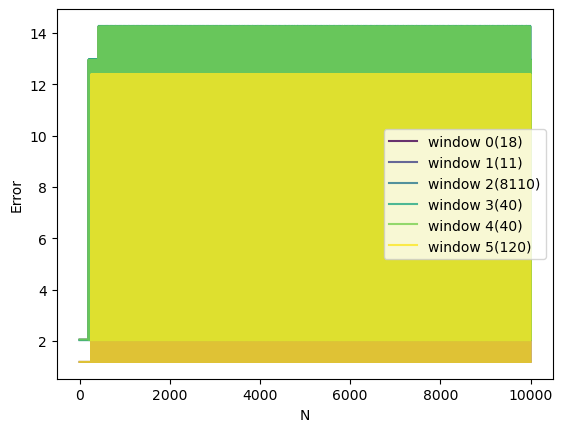

In [22]:
colors = plt.cm.viridis(np.linspace(0, 1, len(all_projection_errors)))
for i in all_projection_errors:
    plt.plot(all_projection_errors[i],color=colors[i], label=f"window {i}({best_iters[i]-1})",alpha=0.8)
    # plt.axvline(x=best_iters[i], color='r', linestyle='--', label=f"最小误差 (窗口 {i})")
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()
# plt.title("每轮 Pauli 投影误差（最小误差标记）")
plt.grid(False)
plt.show()

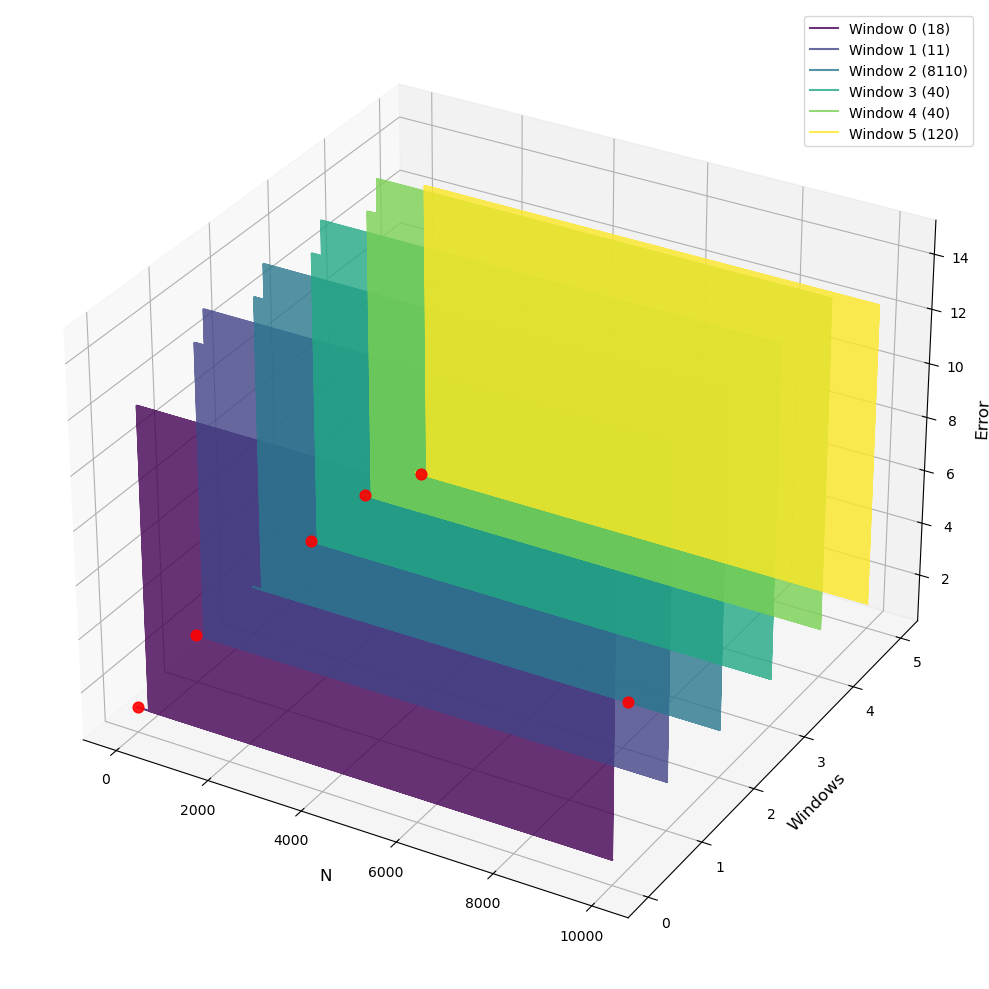

In [23]:
def plot_3d_error_lines(all_projection_errors, best_iters=None, alpha=0.6):
    """
    绘制带半透明效果的 3D 投影误差曲线图，并在图例中加入最佳迭代次数。
    参数：
        all_projection_errors: dict[i] = list of errors
        best_iters: dict[i] = int（最小误差所在迭代）
        alpha: 透明度，0~1，默认 0.6
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_projection_errors)))
    # 存储图例的标签
    legend_labels = []
    for idx, (window_id, errors) in enumerate(sorted(all_projection_errors.items())):
        T = len(errors)
        x = np.arange(T)
        y = np.full(T, window_id)
        z = np.array(errors)
        # 画半透明曲线
        ax.plot(x, y, z, color=colors[idx], alpha=alpha)
        # 标记误差最小点为红色半透明球（不显示在 legend 中）
        if best_iters is not None:
            best_iter = best_iters[window_id]
            ax.scatter([best_iter-1], [window_id], [z[best_iter-1]], 
                       color='red', s=60, alpha=0.9, label='_nolegend_')
        # 生成图例标签：窗口号 + 最佳迭代次数（括号内）
        if best_iters is not None:
            best_iter = best_iters[window_id]
            legend_labels.append(f"Window {window_id} ({best_iter-1})")
        else:
            legend_labels.append(f"Window {window_id}")
    ax.set_xlabel("N", fontsize=12)
    ax.set_ylabel("Windows", fontsize=12)
    ax.set_zlabel("Error", fontsize=12)
    # ax.set_title("带透明度的三维误差曲线图", fontsize=14)
    ax.view_init(elev=30, azim=-60)  # 设置视角：仰角 & 方位角
    ax.grid(True)
    # 更新图例
    ax.legend(legend_labels)
    plt.tight_layout()
    plt.show()

plot_3d_error_lines(all_projection_errors, best_iters,alpha=0.8)


In [24]:
def project_H_to_custom_basis(H_local, k, site_offset):
    """
    将 H_local 投影到 {I, Z, X, σ_+ - σ_-} 张量积空间，
    投影时作为整体计算，写入时将 σ_+-σ_- 拆成两项带正负号。
    """
    # 定义可用于 Op 的原子符号
    primitive_ops = {
        "I": np.eye(2, dtype=complex),
        "Z": np.array([[1, 0], [0, -1]], dtype=complex),
        "X": np.array([[0, 1], [1, 0]], dtype=complex),
        "Y": np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
        "sigma_+": np.array([[0, 1], [0, 0]], dtype=complex),
        "sigma_-": np.array([[0, 0], [1, 0]], dtype=complex),
        "sigma_+-sigma_-": np.array([[0, 1], [-1, 0]], dtype=complex),  # 用于投影
    }
    allowed_basis = ["I", "Z", "X", "Y"]
    ops = []
    for label_seq in itertools.product(allowed_basis, repeat=k):
        # 构造投影用的张量算符
        P = primitive_ops[label_seq[0]]
        for label in label_seq[1:]:
            P = np.kron(P, primitive_ops[label])
        coeff = np.trace(P.conj().T @ H_local)/ (2 ** k)
        if abs(coeff) < 1e-15:
            continue
        # 拆解写入 renormalizer 支持的符号组合
        def expand_labels(label):
            if label == "sigma_+-sigma_-":
                return [("sigma_+", 1), ("sigma_-", -1)]
            else:
                return [(label, 1)]

        # 构造所有组合（带系数符号）
        label_choices = [expand_labels(label) for label in label_seq]
        all_combinations = itertools.product(*label_choices)

        for combo in all_combinations:
            labels, signs = zip(*combo)
            symbol = " ".join(labels)
            total_coeff = coeff * np.prod(signs)
            sites = list(range(site_offset, site_offset + k))
            ops.append(Op(symbol, sites, np.complex128(total_coeff)))

    return ops

def compute_fidelity(state1, state2):
    return abs(np.vdot(state1, state2)) ** 2

def run_dmrg_fidelity_selection_renormalizer(
    all_variants,
    n,
    k,
    original_state_vector,
    bond_dim=64,
    procedure=None,
    verbose=True
):
    """
    对 all_penalized_variants 中每一个版本的哈密顿量使用 renormalizer DMRG，
    用 todense() 还原态矢量并计算保真度，选出最优版本。

    参数：
        all_variants: List[Dict[int, ndarray]] — 多版本局部哈密顿量
        n: int — 总 qubit 数
        k: int — 每个 H_local 的作用范围
        original_state_vector: ndarray — 参考态
        bond_dim: int — 默认最大 bond 维度
        procedure: List[[int, float]] — DMRG 多轮扫描策略
        verbose: bool — 是否打印日志

    返回：
        best_mps, best_idx, best_fid
    """
    if procedure is None:
        procedure = [[bond_dim, 0.5], [bond_dim, 0.2], [bond_dim, 0.0], [bond_dim, 0.0]]

    best_fid = -1
    best_idx = -1
    best_mps = None
    best_energy = None

    for idx, svt_rhos in enumerate(all_variants):
        if verbose:
            print(f"\n 正在运行版本 {idx} 的 DMRG...")

            # 1. 构建 Op 项
        ham_terms = []
        for site, H_local in svt_rhos.items():
            ham_terms.extend(project_H_to_custom_basis(H_local, k, site))

            # 2. 构建 Model 和 MPO
        basis = [BasisHalfSpin(i) for i in range(n)]
        model = Model(basis, ham_terms)
        mpo = Mpo(model)

            # 3. 初始化 MPS + 配置 DMRG
        mps = Mps.random(model, 0, bond_dim)
    
        mps.dtype = np.complex128  
        mps.optimize_config.procedure = procedure
        mps.optimize_config.method = "2site"

            # 4. 优化 MPS
        energies, _ = optimize_mps(mps, mpo)
        energy = min(energies)

            # 5. 恢复态矢量 + 保真度计算
        state_vec = mps.todense()
        # print(state_vec)
        state_vec /= np.linalg.norm(state_vec)
        fid = compute_fidelity(original_state_vector, state_vec)

        if verbose:
            print(f" 版本 {idx}：能量 = {energy:.12f}，保真度 = {fid:.12f}")

        if fid > best_fid:
            best_fid = fid
            best_energy = energy
            best_idx = idx
            best_mps = mps
        print(f"\n 最优版本 = {best_idx}，保真度 = {best_fid:.16f}，能量 = {best_energy:.16f}")
    return best_mps, best_idx, best_fid


def penalize_max_eigenstates_chain(svt_Y_rhos_init, num_variants=2**k, shift_per_round=-20.0):
    """
    每一轮将每个 H_i 的最大本征值降低 shift_per_round，生成新哈密顿量版本
    返回：List of svt_Y_rhos 版本
    """
    variants = [svt_Y_rhos_init]

    current = svt_Y_rhos_init
    for _ in range(1, num_variants):
        new_version = {}
        for i, H in current.items():
            eigvals, eigvecs = np.linalg.eigh(H)
            min_idx = np.argmin(eigvals)
            eigvals[min_idx] += shift_per_round  

            H_new = sum(
                eigvals[j] * np.outer(eigvecs[:, j], eigvecs[:, j].conj())
                for j in range(len(eigvals))
            )
            new_version[i] = H_new

        variants.append(new_version)
        current = new_version  

    return variants


In [25]:
# 禁用 renormalizer 内部所有日志输出
logging.getLogger("renormalizer").setLevel(logging.CRITICAL + 1)
all_penalized_variants = penalize_max_eigenstates_chain(svt_Y_rhos, num_variants=2**k, shift_per_round=20.0)
bond_dim=64
procedure_custom = [
    [bond_dim, 0.5],[bond_dim, 0.4],[bond_dim, 0.2],[bond_dim, 0.0]
]*100

best_mps, best_idx, best_fid = run_dmrg_fidelity_selection_renormalizer(
    all_variants=all_penalized_variants,
    n=n,
    k=k,
    original_state_vector=evolved_state,
    bond_dim=bond_dim,
    procedure=procedure_custom,
    verbose=True
)
print(best_mps.bond_dims)



 正在运行版本 0 的 DMRG...
 版本 0：能量 = 0.001324568724，保真度 = 0.000000000000

 最优版本 = 0，保真度 = 0.0000000000000000，能量 = 0.0013245687243145

 正在运行版本 1 的 DMRG...
 版本 1：能量 = 0.012105952599，保真度 = 0.000000000000

 最优版本 = 1，保真度 = 0.0000000000000000，能量 = 0.0121059525989472

 正在运行版本 2 的 DMRG...
 版本 2：能量 = 0.106981154464，保真度 = 0.000000000000

 最优版本 = 1，保真度 = 0.0000000000000000，能量 = 0.0121059525989472

 正在运行版本 3 的 DMRG...
 版本 3：能量 = 0.252458564439，保真度 = 0.001450119800

 最优版本 = 3，保真度 = 0.0014501197996223，能量 = 0.2524585644385767

 正在运行版本 4 的 DMRG...
 版本 4：能量 = 0.480221949478，保真度 = 0.991680473932

 最优版本 = 4，保真度 = 0.9916804739320874，能量 = 0.4802219494775670

 正在运行版本 5 的 DMRG...
 版本 5：能量 = 0.916427700952，保真度 = 0.991619469254

 最优版本 = 4，保真度 = 0.9916804739320874，能量 = 0.4802219494775670

 正在运行版本 6 的 DMRG...
 版本 6：能量 = 4.120589554826，保真度 = 0.971458466997

 最优版本 = 4，保真度 = 0.9916804739320874，能量 = 0.4802219494775670

 正在运行版本 7 的 DMRG...
 版本 7：能量 = 9.822995631431，保真度 = 0.875248820362

 最优版本 = 4，保真度 = 0.9916804739320874，

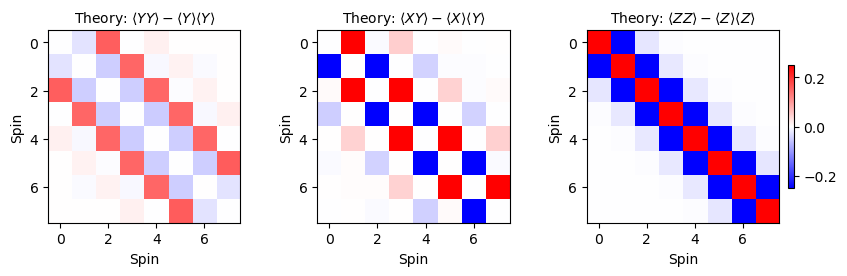

In [26]:
evolved_state=best_mps.todense()
mat_YY = build_corr_matrix(evolved_state, "Y", "Y", n)
mat_XY = build_corr_matrix(evolved_state, "X", "Y", n)
mat_ZZ = build_corr_matrix(evolved_state, "Z", "Z", n)

# 绘图
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, mat, title in zip(
    axs,
    [mat_YY, mat_XY, mat_ZZ],
    [r"Theory: $\langle YY\rangle - \langle Y\rangle\langle Y\rangle$",
     r"Theory: $\langle XY\rangle - \langle X\rangle\langle Y\rangle$",
     r"Theory: $\langle ZZ\rangle - \langle Z\rangle\langle Z\rangle$"]
):
    im = ax.imshow(mat, cmap="bwr", vmin=-0.25, vmax=0.25)  # 设置vmin和vmax以确保一致性
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Spin", fontsize=10)
    ax.set_ylabel("Spin", fontsize=10)

# 调整子图间距，避免颜色条与图形重叠
fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.85)  # 调整右侧边距以为颜色条腾出空间

# 将颜色条放置在最右侧，并设置为竖直方向
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.4, pad=0.01)
cbar.ax.tick_params(labelsize=10)  # 调整颜色条刻度标签的字体大小

plt.show()